Implement the function stubs in altproj_code.py and complete lines with "###"

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

from numpy.random import rand, randn
from scipy.linalg import inv, svd
from scipy.optimize import linprog
from tqdm.notebook import tqdm

from altproj_code import null_space, altproj, lp_altproj, kaczmarz, mnist_pairwise_altproj, mnist_multiclass_altproj


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Exercise 1
(10 pts program + 5 pts solution)
Let $U$ and $W$ be subspaces of $\mathbb{R}^5$ that are spanned, respectively, by the columns of the matrices $A$ and $B$ (shown below). 
Write a function `altproj(A,B,v0,n)` that returns $\underline{v}_{2n}$ after $2n$ steps of alternating projection onto $U$ and $W$ starting from $\underline{v}_0$. 
Use this function to find the orthogonal projection of $\underline{v}_0$ (shown below) onto $ U \cap W $. How large should $n$ be chosen so that the projection is correct to 4 decimal places (e.g., absolute error at most 0.0001 in each coordinate)?
$$
A = 
\begin{bmatrix}
 3 & 2 & 3 \\ 1 & 5 & 7 \\ 4 & 11 & 13 \\ 1 & 17 & 19 \\ 5 & 23 & 29
\end{bmatrix}, \qquad
B = 
\begin{bmatrix}
 1 & 1 & 2.5 \\ 2 & 0 & 6 \\ 2 & 1 & 12 \\ 2 & 0 & 18 \\ 6 & -3 & 26
\end{bmatrix}, \qquad
\underline{v}_0 =
\begin{bmatrix}
 1 \\2 \\ 3 \\ 4 \\ 5
\end{bmatrix}
$$
To find the intersection of $U$ and $W$, we note that the following Python snippet returns a matrix whose columns span $ U \cap W $
```
basis_UintW = np.hstack([A, B]) @ null_space(np.hstack([A, -B])) 
```

how large n is for projection to be correct to 0.0001: 14


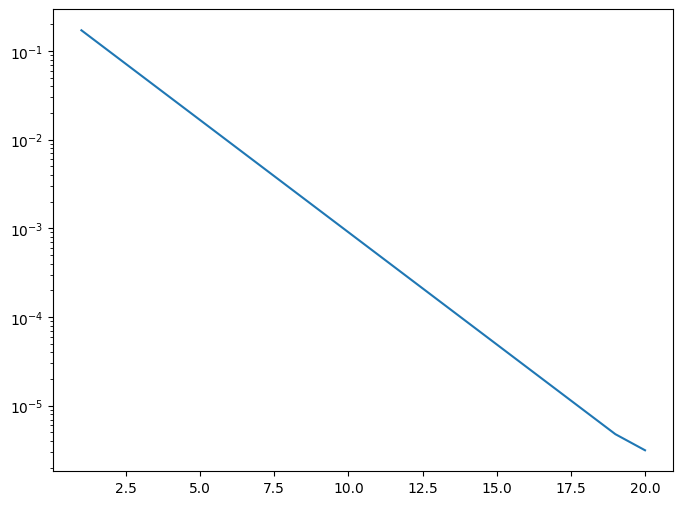

In [10]:
A = np.array([[3, 1, 4, 1, 5], [2, 5, 11, 17, 23], [3, 7, 13, 19, 29]]).T
B = np.array([[1, 2, 2, 2, 6], [1, 0, 1, 0, -3], [2.5, 6, 12, 18, 26]]).T
v0 = np.array([1, 2, 3, 4, 5])
n = 20
v, err = altproj(A, B, v0, n)
for i in range(len(err)):
    if err[i] < 0.0001:
        print("how large n is for projection to be correct to 0.0001:",i+1)
        break
plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, n + 1), err)

### Exercise 2
(10 pts program + 5 pts solution)
Write a function `kaczmarz(A,b,I)` that returns a matrix $X$ with $I$ columns corresponding
to the Kaczmarz iteration after $i = 1, 2, ..., I$ full passes through the Kaczmarz algorithm
for the matrix $A$ and right-hand side $\underline{b}$ (e.g., one full pass equals $m$ steps). 
Use this function to find the minimum-norm solution of linear system $A \underline{x} = \underline{b}$ for
$$
A = 
\begin{bmatrix}
 2 & 5 & 11 & 17 & 23 \\ 3 & 7 & 13 & 19 & 29
\end{bmatrix}, \qquad
\underline{b} =
\begin{bmatrix}
 228 \\ 227
\end{bmatrix}
$$
Plot the error (on a log scale) versus the number of full passes for $I = 500$.

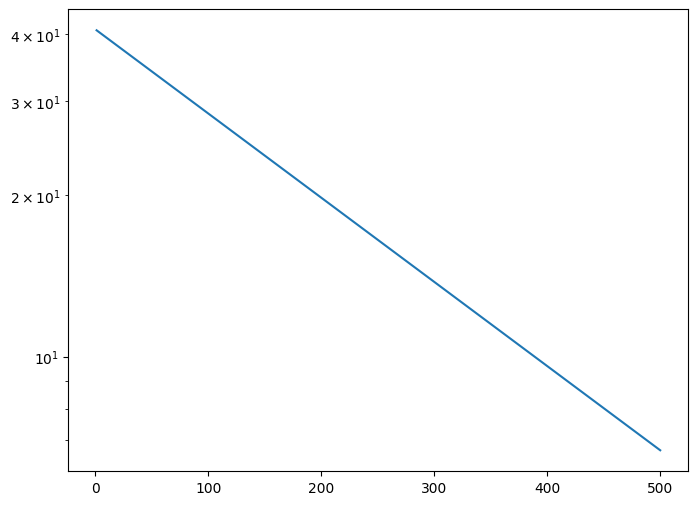

In [11]:
A = np.array([[2, 5, 11, 17, 23], [3, 7, 13, 19, 29]])
b = np.array([228, 227])
I = 500
X, err = kaczmarz(A, b, I)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

### Exercise 3
(10 pts)
Repeat the experiment with $I = 100$ for a random system defined by `A = randn(500,1000)`
and `b = A @ randn(1000)`. 
Compare the iterative solution with the true minimum-norm solution 
$ \hat{\underline{x}} = A^H {(A A^H)}^{-1} \underline{b} $.

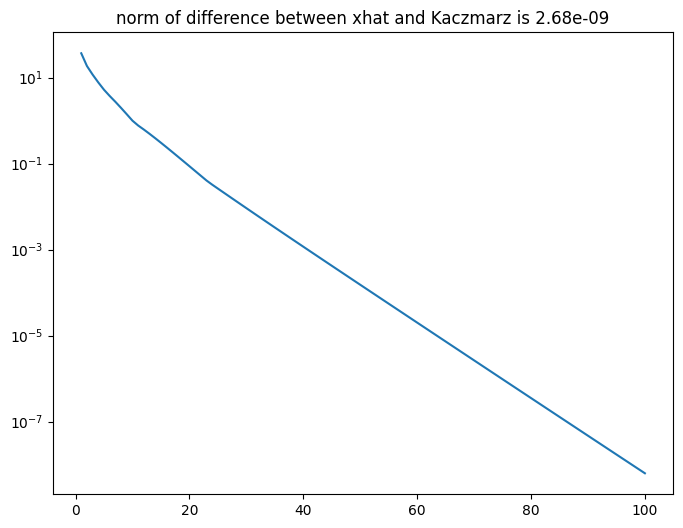

In [12]:
A = randn(500, 1000)
b = A @ randn(1000)
I = 100
X, err = kaczmarz(A, b, I)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

x_hat = A.T@np.linalg.inv(A@A.T) @ b
x_hat_err = np.linalg.norm(x_hat - X[:, -1])

plt.title(f'norm of difference between xhat and Kaczmarz is {x_hat_err:.2e}');

### Exercise 4
(10 pts program + 5 pts solution)
Consider the linear program
$$
\min ~ \underline{c}^T \underline{x}
\quad \textrm{subject to} \quad
A \underline{x} \ge \underline{b}, \quad \underline{x} \ge 0
$$
with
$$
\underline{c} = 
\begin{bmatrix}
    3 \\ -1 \\ 2
\end{bmatrix}, \quad
A = 
\begin{bmatrix}
    2 & -1 & 1 \\ 1 & 0 & 2 \\ -7 & 4 & -6
\end{bmatrix}, \quad
\underline{b} = 
\begin{bmatrix}
    -1 \\ 2 \\ 1
\end{bmatrix}, \quad
$$
Let $p^*$ denote the optimum value of this program.
Then, $p^* \le 0$ is satisfied if and only if there is a non-negative $\underline{x} = (x_1, x_2, x_3)^T$ satisfying
$$
\begin{align}
2x_1 - x_2 + x_3 &\ge -1 \\
x_1 + 2x_3 &\ge 2 \\
-7x_1 + 4x_2 - 6x_3 &\ge 1 \\
-3x_1 + x_2 - 2x_3 &\ge 0
\end{align}
$$
where the last inequality restricts the value of the program to be at most $0$.
One can find the optimum value `p` and an optimizer `x` with the command 
```
res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * c.size, method=’interior-point’)
x, p = res.x, res.fun
```

Write a function `x=lp_altproj(A,b,I,s=1,d=0)` that uses alternating projections onto half spaces (starting from $\underline{x}_0 = 0$).  The program should use $I$ passes through the set of inequality constraints (with step size $s$). In each pass, it should first project sequentially onto the constraints $A\underline{x}\geq\underline{b}$ and then enforce all at once $\underline{x} \geq d \underline{1}$. It should output the final vector $\underline{x}_{mI}$ and a vector containing the maximum feasibility gap $g_{k}=\max_{j}\big[\underline{b}-A\underline{x}_{km}\big]_{j}$ for $k=1,2,\ldots,I$.

Note: The non-negativity constraints $ x_1 \ge 0, x_2 \ge 0, x_3 \ge 0 $ are handled by the default parameter $d=0$.

Use this program to find a vector that satisfies all the inequalities. 
How many iterations are required so that the feasibility gap is at most 0.0001?

     con: array([], dtype=float64)
     fun: 1.863842413740713e-12
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([-8.69082584e-13,  3.96171984e-12,  1.00000000e+00])
  status: 0
 success: True
       x: array([1.50428116e-12, 2.00000000e+00, 1.00000000e+00])
num iterations for feasibility gap is atmost 0.0001: 96
True True
[0.]


C:\Users\fuzzi\AppData\Local\Temp\ipykernel_15720\1612130747.py:5: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * c.size, method='interior-point')


array([0., 2., 1.])

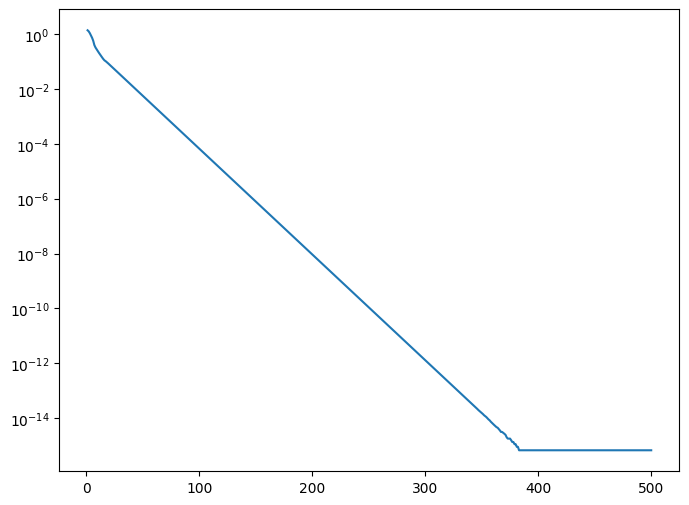

In [55]:
c = np.array([3, -1, 2])
A = np.array([[2, -1, 1], [1, 0, 2], [-7, 4, -6]])
b = np.array([-1, 2, 1])

res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * c.size, method='interior-point')
print(res)

I = 500
# Do not forget constraint xi >= 0
A1 = np.concatenate((A, [-1*c]),axis=0)
b1 = np.concatenate((b,np.array([0])),axis=0)

x, err = lp_altproj(A1, b1, I)
for i in range(len(err)):
    if err[i] < 0.0001:
        print("num iterations for feasibility gap is atmost 0.0001:", i+1)
        break

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

x = np.round(x,10)
print(np.all(A @ x - b >= 0), np.all(x >= 0))
# print(c.reshape(1, -1) @ x)
x

### Exercise 5
(10 pts)
Consider the “random” convex optimization problem defined by
```
c = randn(1000)
A = np.vstack([-np.ones((1, 1000)), randn(500, 1000)])
b = np.concatenate([[-1000], A[1:] @ rand(1000)])
```
Modify $A$ and $b$ (by adding one row and one element) so that your function can be used to prove that the value of the convex optimization problem, in (3), is at most −1000. Try using `I = 1000` passes
through all 501 inequality constraints.
This type of iteration typically terminates with an “almost feasible” $\underline{x}$. 
To find a strictly feasible point, try running the same algorithm with the argument $ \underline{b} + \epsilon $ for some small $ \epsilon > 0 $  (e.g., try $ \epsilon = {10}^{-6} $).
Then, the resulting $ \underline{x} $ can satisfy `np.all(A @ x - b > 0)`

True True [-1000.000001]


C:\Users\fuzzi\AppData\Local\Temp\ipykernel_15720\3520404108.py:17: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * 1000, method='interior-point')


-1198.5327823524037


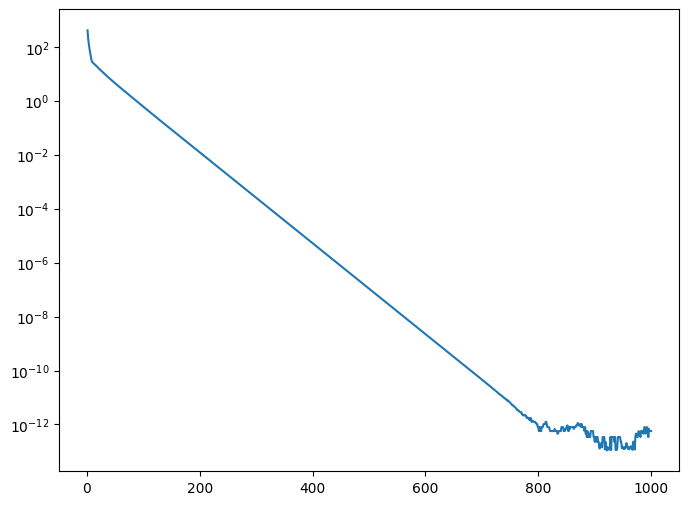

In [283]:
np.random.seed(0)
c = randn(1000)
A = np.vstack([-np.ones((1, 1000)), randn(500, 1000)])
b = np.concatenate([[-1000], A[1:] @ rand(1000)])

I, ep = 1000, 1e-6
# Do not forget constraint xi >= 0, and c^T x <= -1000
A1 = np.concatenate((A,[-1*c]))
b1 = np.concatenate((b,[1000]))

x, err = lp_altproj(A1, b1 + ep, I,d=ep)

print(np.all(A @ x - b > 0), np.all(x > 0), c.reshape(1, -1) @ x)
plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * 1000, method='interior-point')
print(res.fun)

### Exercise 6
(10 pts) Repeat the MNIST training exercise from the Least-Squares Handout using the training method described above. 
First, extract the indices of all the 2’s and randomly separate the samples into equal-sized training and testing groups. 
Second, do the same for the 3’s. Now, extend each vector to length 785 by appending a −1. This will allow the system to learn a general hyperplane separation.

Next, use alternating projections to design a linear classifier to separate for 2’s and 3’s. For the resulting linear function, report the classification error rate and confusion matrices for the both the training and test sets. Is there any benefit to choosing $s<1$? Also, for the test set, compute the histogram of the function output separately for each class and then plot the two histograms together. 
This shows easy or hard it is to separate the two classes.

Depending on your randomized separation into training and test sets, the training data may or may not be linearly separable. 
Comment on what happens to the test set performance when the error rate does converge to zero for the training set.

Pairwise experiment, mapping 2 to -1, mapping 3 to 1
training error = 25.12%, testing error = 24.50%
Training Confusion matrix:
 [[1017 1071]
 [   0 2175]]
Testing Confusion matrix:
 [[1049 1040]
 [   5 2171]]


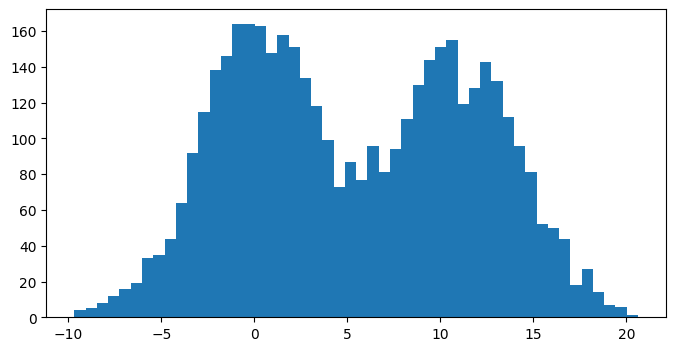

In [284]:
# read mnist csv file to a dataframe
df = pd.read_csv('mnist_train.csv')
# append feature column by merging all pixel columns
df['feature'] = df.apply(lambda row: row.values[1:], axis=1)
# only keep feature and label column
df = df[['feature', 'label']]

solver = lambda A, b: lp_altproj(A, b + 1e-6, 100, 1, -np.Inf)
z_hat, res = mnist_pairwise_altproj(df, 2, 3, solver, verbose=True)

### Exercise 7
(10 pts program + 5 pts solution)
Describe how this approach should be extended to multi-class linear classification
(parameterized by $ Z \in \mathbb{R}^{n \times d} $) where the classifier maps a vector $\underline{v}$ to class $j$ if the $j$-th element
of $ Z^T \underline{v} $ is the largest element in the vector. 
Conceptually, we can think of $Z$ as defining $d$ different linear functions of $\underline{v}$ that compute a score for each class. Then, the classifier chooses the class with the highest score.

For each training sample, one can project onto the set of weights such that that the correct element of the output vector has the largest value (e.g., this gives 9 inequalities per training sample). Then, use the implied alternating-projection solution to design a multi-class classifier for MNIST. Report both the overall classification error rate and confusion matrices for the both the training and test sets. Is there any benefit to choosing $s < 1$?

In [145]:
A = np.array([[-2, 1],[1, -2]])
b = np.array([2,2])
v, err = lp_altproj(A, b, 10, d=-np.Inf)
assert 0.05188146770730828 == err[-1], err[-1]
assert np.allclose([-1.96541235, -1.98270618],v), v

A = np.array([[-4, 3,3],[3, -4, 3],[3, 3, -4]])
b = np.array([3,4,5])
v, err = lp_altproj(A, b, 10, d=-np.Inf)
assert 0.7250551085496868 == err[-1],err[-1]
assert np.allclose([2.01660003, 1.81980856, 1.62730644],v), v

In [279]:
solver = lambda A, b: lp_altproj(A, b + 1e-6, 100, 0.01, -np.Inf)

Z, res = mnist_multiclass_altproj(df, solver)
print(Z)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html